In [ ]:
# Miscellaneous testing for Eric - others please do not edit - git doesn't play nice with jupyter notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os, sys
import torch
import optuna
import ruamel.yaml as yaml
import re

In [ ]:

path = "../active/outputs/test/move_data.csv"
results = pd.read_csv(path,index_col=0)
results["cumulative_reward"] = results.reward.cumsum()
fig = plt.figure(constrained_layout=False,figsize=(13,6))
ax=sns.lineplot(data=results,x=results.index, y = "cumulative_reward")
ax2 = plt.twinx()
sns.lineplot(data=results.epsilon, color="b", ax=ax2)

path2 = "../active/outputs/test/episode_data.csv"
episode_results = pd.read_csv(path2,index_col=0)
fig2 = plt.figure(constrained_layout=False,figsize=(13,6))
ax3 = sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)

path3 = "../active/outputs/test/loss_data.csv"
loss_results = pd.read_csv(path3,index_col=0)
fig3 = plt.figure(constrained_layout=False,figsize=(13,6))
ax4 = sns.lineplot(data=loss_results,x=loss_results.index, y = loss_results.loss)

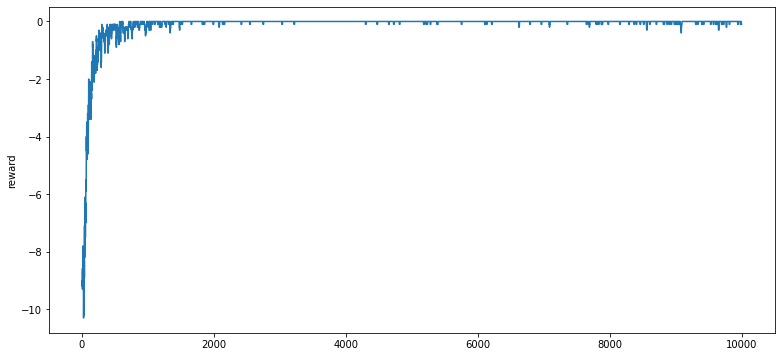

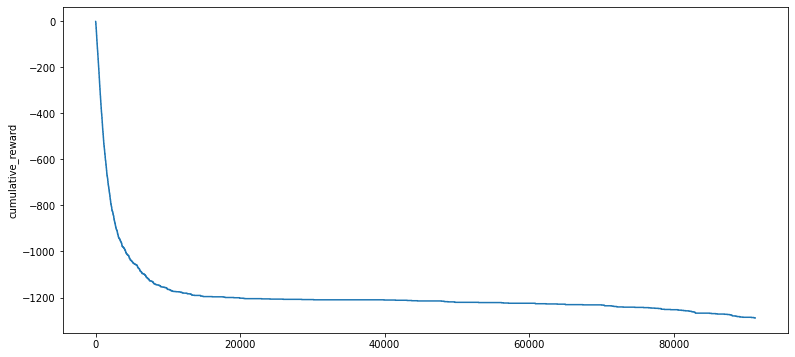

In [13]:
# Multi run results
#path = "../active/outputs/test/other_clockwiseTwoFree"
#path = "../active/outputs/test/other_clockwiseTwoFreeAlt"
#path = "../active/outputs/test/other_clockwiseZeroStart"
#path = "../active/outputs/test/other_1_1_shape_4m"
path = "../active/outputs/test/other_1_2_shape_4m"

fig = plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,1):
    run_path = path + "/"+str(i)+"/episode_data.csv"
    episode_results = pd.read_csv(run_path,index_col=0)
    sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)
fig2= plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,1):
    run_path = path + "/"+str(i)+"/move_data.csv"
    results = pd.read_csv(run_path,index_col=0)
    results["cumulative_reward"] = results.reward.cumsum()
    sns.lineplot(data=results,x=results.index, y = "cumulative_reward")

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
study_name = "naive_n8_Rule_001_8reps"
storage_name = "sqlite:///../active/outputs/tuning/{}.db".format(study_name)
study = optuna.study.load_study(study_name=study_name,storage=storage_name)

In [ ]:
study.best_params

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
#import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split


In [ ]:
plot_param_importances(study)

In [ ]:
#print(np.ravel_multi_index((o_row,o_col,b_index),(6,6,4)))
print(np.unravel_index(72, (6,6,4)))

In [5]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

In [11]:
# Location of rule runs
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/rule_runs/"
runs_to_analyze = ["initial_run_naive_n2","initial_run_naive_n4","initial_run_naive_n6","initial_run_n2","initial_run_n4","initial_run_n6"]
#runs_to_analyze = ["test_folder"]

#loader = yaml.SafeLoader
# loader.add_implicit_resolver(
# u'tag:yaml.org,2002:float',
# re.compile(u'''^(?:
#     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
# |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
# |\\.[0-9_]+(?:[eE][-+][0-9]+)?
# |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
# |[-+]?\\.(?:inf|Inf|INF)
# |\\.(?:nan|NaN|NAN))$''', re.X),
# list(u'-+0123456789.'))

# Create lists that will hold dataframes for concatenation
episode_df_list = []
move_df_list = []

# Loop over the specified rule runs
for run in runs_to_analyze:
    #print(run)
    # Form complete run path
    run_path = rule_runs_path+run
    #print(run_path)
    # Get the experiments for that run (each one is a set of trials for a particular rule)
    experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]
    #print(experiments)
    # Loop over the experiments
    for experiment in experiments:
        # Get the neptune id
        neptune_trial = experiment.split("_")[0]
        # String length may vary
        trial_str_length = len(neptune_trial)
        # Rule is everything after the neptune id and an _ character
        rule_name = experiment[trial_str_length+1:]
        #print(neptune_trial)
        #print(rule_name)
        # For complete experiment path
        experiment_path = os.path.join(run_path,experiment)
        #print(experiment_path)
        trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]
        #print(trials)
        for trial in trials:
            trial_path = os.path.join(experiment_path,trial)
            # Get parameters
            yaml_path = os.path.join(trial_path,"data.yaml")
            with open(yaml_path, 'r') as param_file:
                args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                featurization =args["FEATURIZATION"]
            # Import episodic data and process relevant columns
            episodic_data_path = os.path.join(trial_path,"episode_data.csv")
            trial_results = pd.read_csv(episodic_data_path,index_col=0)
            trial_results["rule"]=rule_name
            trial_results["params"]=run
            trial_results["memory"]=int(run[-1])
            trial_results["experiment_id"]=neptune_trial
            trial_results["trial"]=trial
            trial_results["featurization"]=featurization
            trial_results["ep_error"]=-1*trial_results["reward"]
            trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
            episode_df_list.append(trial_results)

# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)

In [12]:
episode_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,0,-7.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,7.0,7.0
1,1,-12.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,12.0,19.0
2,2,-11.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,11.0,30.0
3,3,-6.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,6.0,36.0
4,4,-12.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,12.0,48.0


In [16]:
complete_list = episode_results_df.rule.unique()
rules_list = [{"name":"all_rules","rules":complete_list,"y":[0,3000]},
                {"name":"shape_rules","rules":["1_1_shape_4m","1_2_shape_4m", "1_1_shape_3m_cua"],"y":[0,4000]}, 
                {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFree","clockwiseTwoFreeAlt"],"y":[0,4000]},
                {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
                {"name":"color_rules","rules":["1_1_color_4m","1_2_color_4m","1_1_color_3m_cua"],"y":[0,3000]},
                {"name":"bottom_top_rules","rules":["bottom_then_top","bottomLeft_then_topRight"],"y":[0,1000]}]


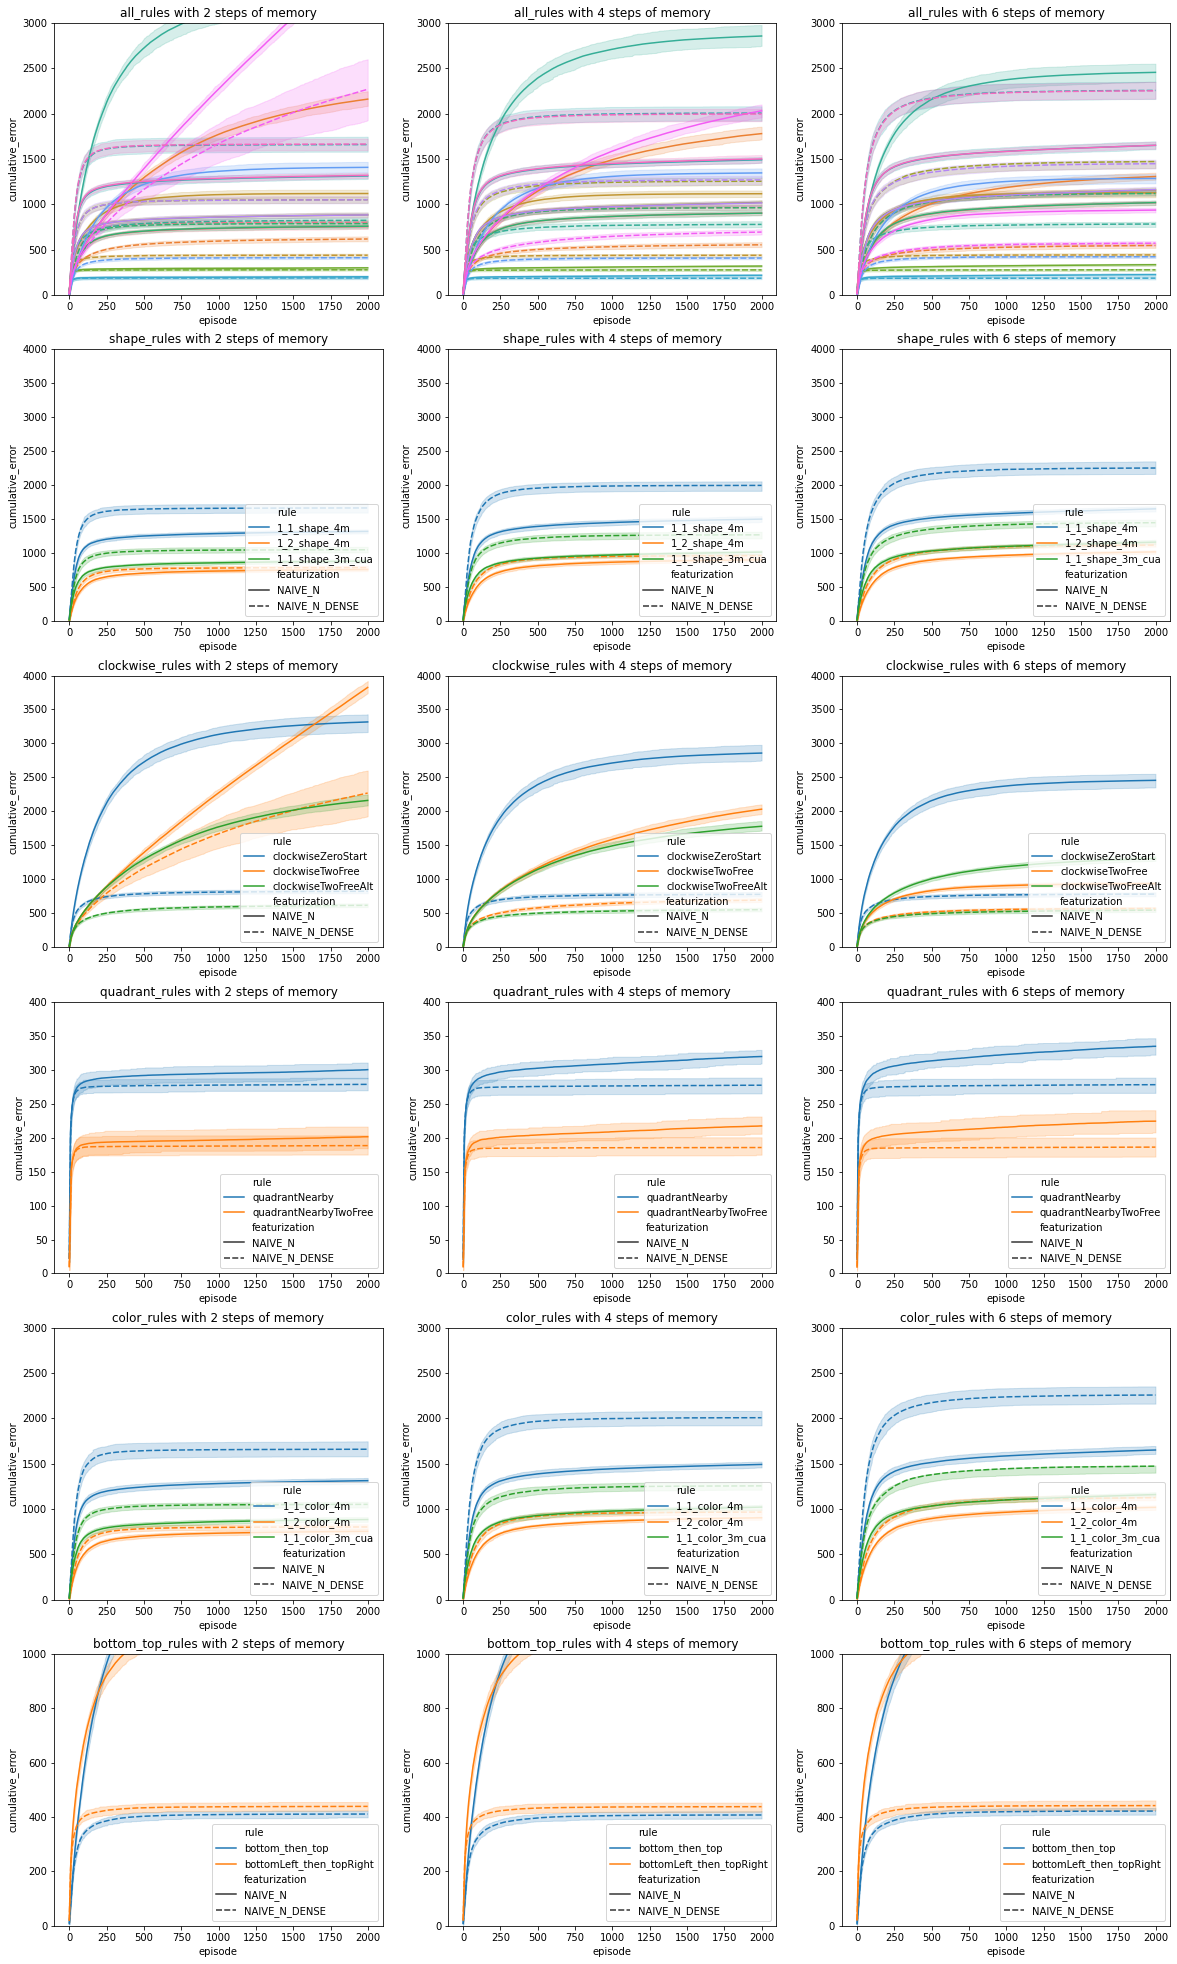

In [21]:
# Create a figure grid
fig = plt.figure(figsize=(20,35))
steps = [2,4,6]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))

for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",errorbar=('ci', 95),estimator=np.median,n_boot=100,hue="rule",hue_order=sub_list,style="featurization")
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])
        if i>0:
            ax.legend(loc="lower right")
        else:
            ax.legend('',frameon=False)

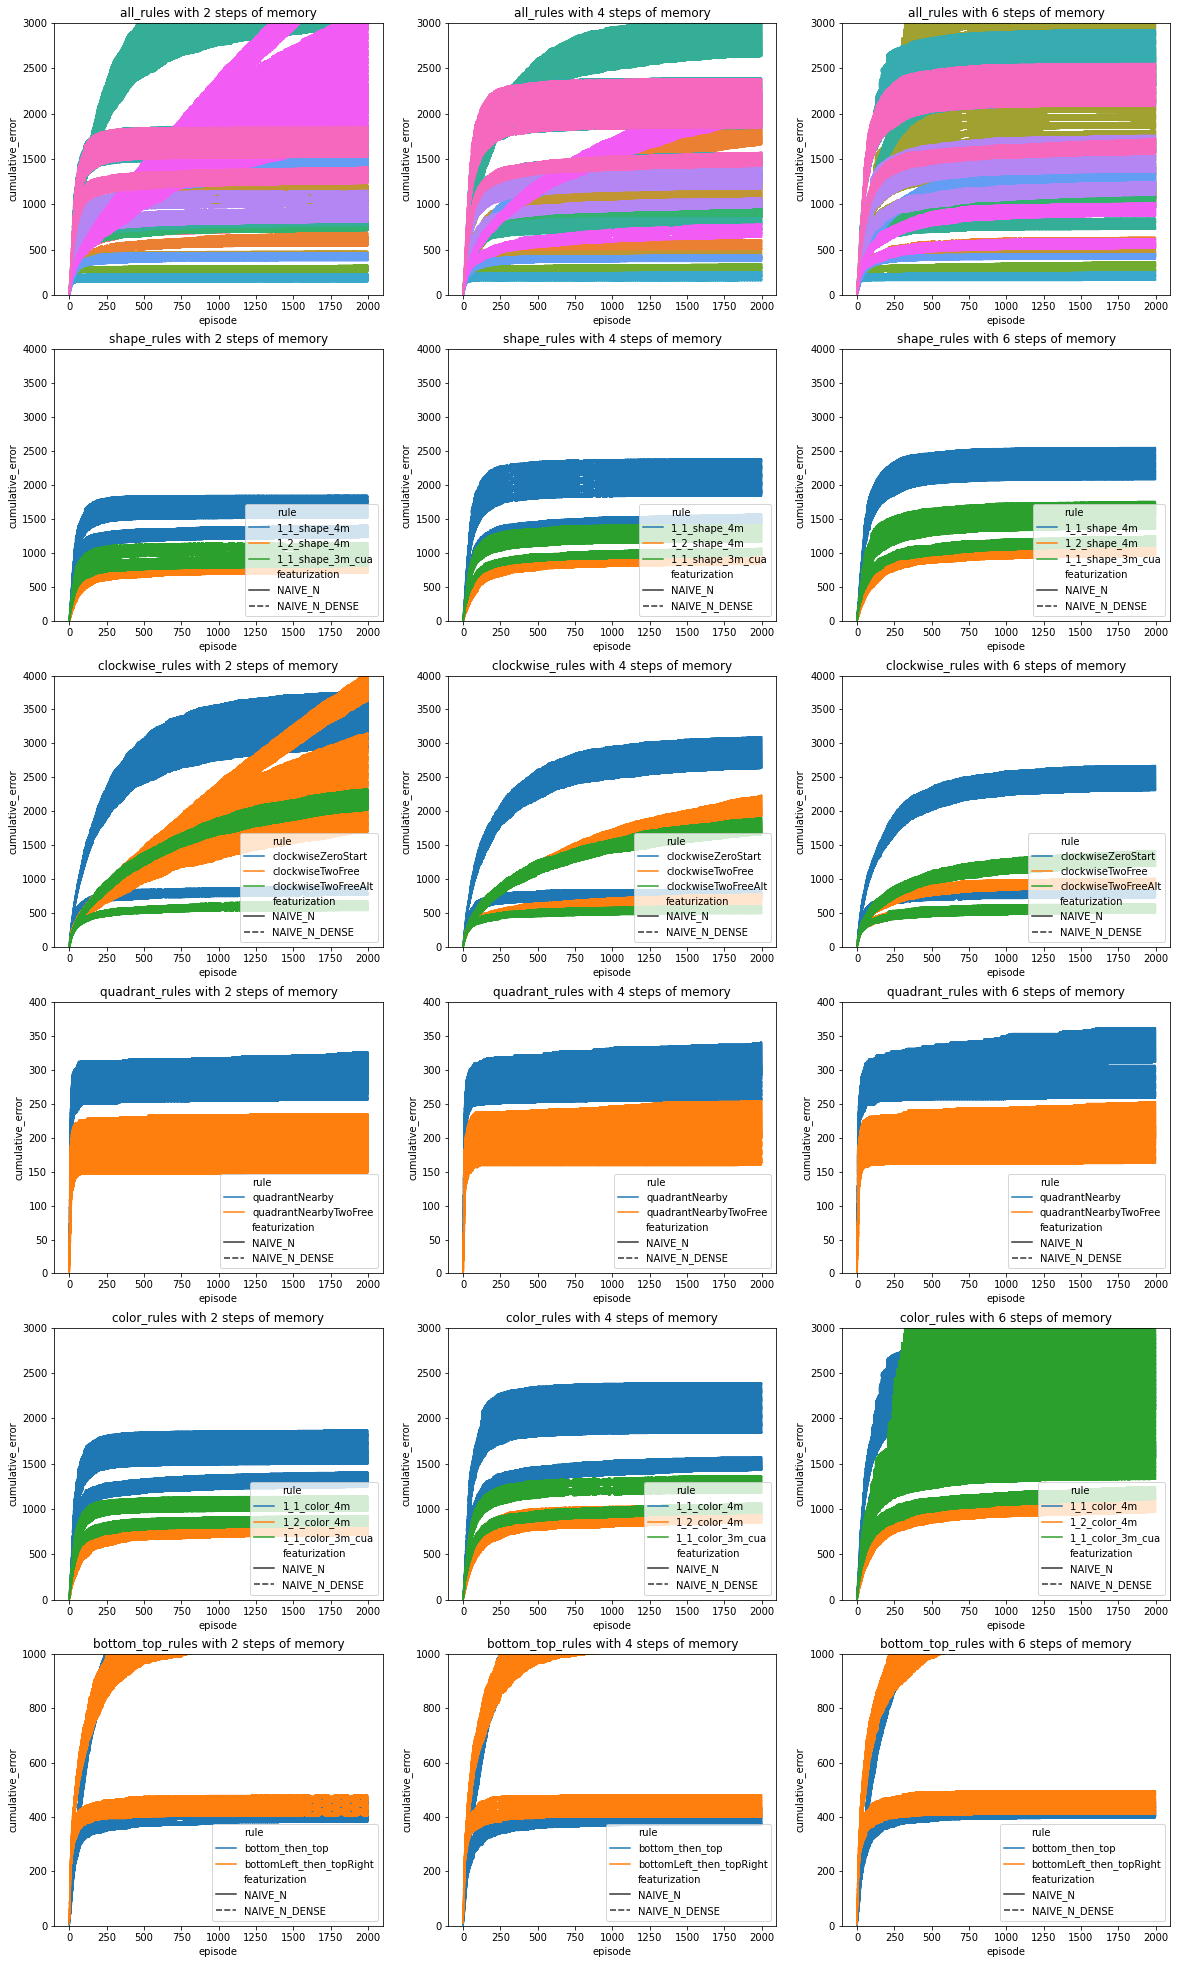

In [18]:
# Create a figure grid
fig = plt.figure(figsize=(20,35))
steps = [2,4,6]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))

for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",estimator=None,hue="rule",hue_order=sub_list,style="featurization")
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])
        if i>0:
            ax.legend(loc="lower right")
        else:
            ax.legend('',frameon=False)

In [6]:

path_2 = "/Users/eric/repos/gohr/active/outputs/rule_runs/archive/original_no_record/initial_run_n2"
path_4 = "/Users/eric/repos/gohr/active/outputs/rule_runs/archive/original_no_record/initial_run_n4"
path_6 = "/Users/eric/repos/gohr/active/outputs/rule_runs/archive/original_no_record/initial_run_n6"
path_8 = "/Users/eric/repos/gohr/active/outputs/rule_runs/archive/original_no_record/initial_run_n8"
results =[{"path":path_2,"df":None,"steps":2},
            {"path":path_4,"df":None,"steps":4},
            {"path":path_6,"df":None,"steps":6},
            {"path":path_8,"df":None,"steps":8}]
rules = [name for name in os.listdir(path_2) if name!=".DS_Store"]
print(rules)
for j in range(0,len(results)):
    path = results[j]["path"]
    print(path)
    results_list = []
    for rule in rules:
        rule_path = path+"/"+rule
        print(rule_path)
        rule_name = rule[6:]
        #print(rule_name)
        #print(run_path)
        for i in np.arange(0,8):
            trial_path = rule_path + "/"+str(i)+"/episode_data.csv"
            #print(trial_path)
            episode_results = pd.read_csv(trial_path,index_col=0)
            episode_results["rule"]=rule_name
            episode_results["trial"]=i
            episode_results["ep_error"]=-1*episode_results["reward"]
            episode_results["cumulative_error"] = episode_results.ep_error.cumsum()
            results_list.append(episode_results)
    results_df = pd.concat(results_list,ignore_index=True)
    results[j]["df"]=results_df

['GOH1-173_1_2_color_4m', 'GOH1-169_clockwiseTwoFreeAlt', 'GOH1-176_bottomLeft_then_topRight', 'GOH1-174_1_1_color_3m_cua', 'GOH1-170_quadrantNearby', 'GOH1-164_1_2_shape_4m', 'GOH1-167_clockwiseZeroStart', 'GOH1-172_1_1_color_4m', 'GOH1-171_quadrantNearbyTwoFree', 'GOH1-175_bottom_then_top', 'GOH1-166_1_1_shape_3m_cua', 'GOH1-168_clockwiseTwoFree', 'GOH1-162_1_1_shape_4m']
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-173_1_2_color_4m
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-169_clockwiseTwoFreeAlt
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-176_bottomLeft_then_topRight
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-174_1_1_color_3m_cua
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-170_quadrantNearby
/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n2/GOH1-

FileNotFoundError: [Errno 2] No such file or directory: '/Users/eric/repos/gohr/active/outputs/rule_runs/initial_run_naive_n4/GOH1-173_1_2_color_4m/0/episode_data.csv'

In [3]:
rules = [name for name in os.listdir(path) if name!=".DS_Store"]
print(rules)
count_steps = len(results)

complete_list = results_df.rule.unique()
rules_list = [{"name":"all_rules","rules":complete_list,"y":[0,3000]},
                {"name":"shape_rules","rules":["1_1_shape_4m","1_2_shape_4m", "1_1_shape_3m_cua"],"y":[0,3000]}, 
                {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFree","clockwiseTwoFreeAlt"],"y":[0,1000]},
                {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
                {"name":"color_rules","rules":["1_1_color_4m","1_2_color_4m","1_1_color_3m_cua"],"y":[0,3000]},
                {"name":"bottom_top_rules","rules":["bottom_then_top","bottomLeft_then_topRight"],"y":[0,500]}]


['other_1_1_color_3m_cua', 'other_clockwiseZeroStart', 'other_1_1_shape_3m_cua', 'other_1_1_color_4m', 'other_clockwiseTwoFreeAlt', 'other_1_2_shape_4m', 'other_quadrantNearbyTwoFree', 'other_clockwiseTwoFree', 'other_bottomLeft_then_topRight', 'other_1_1_shape_4m', 'other_bottom_then_top', 'other_quadrantNearby', 'other_1_2_color_4m']


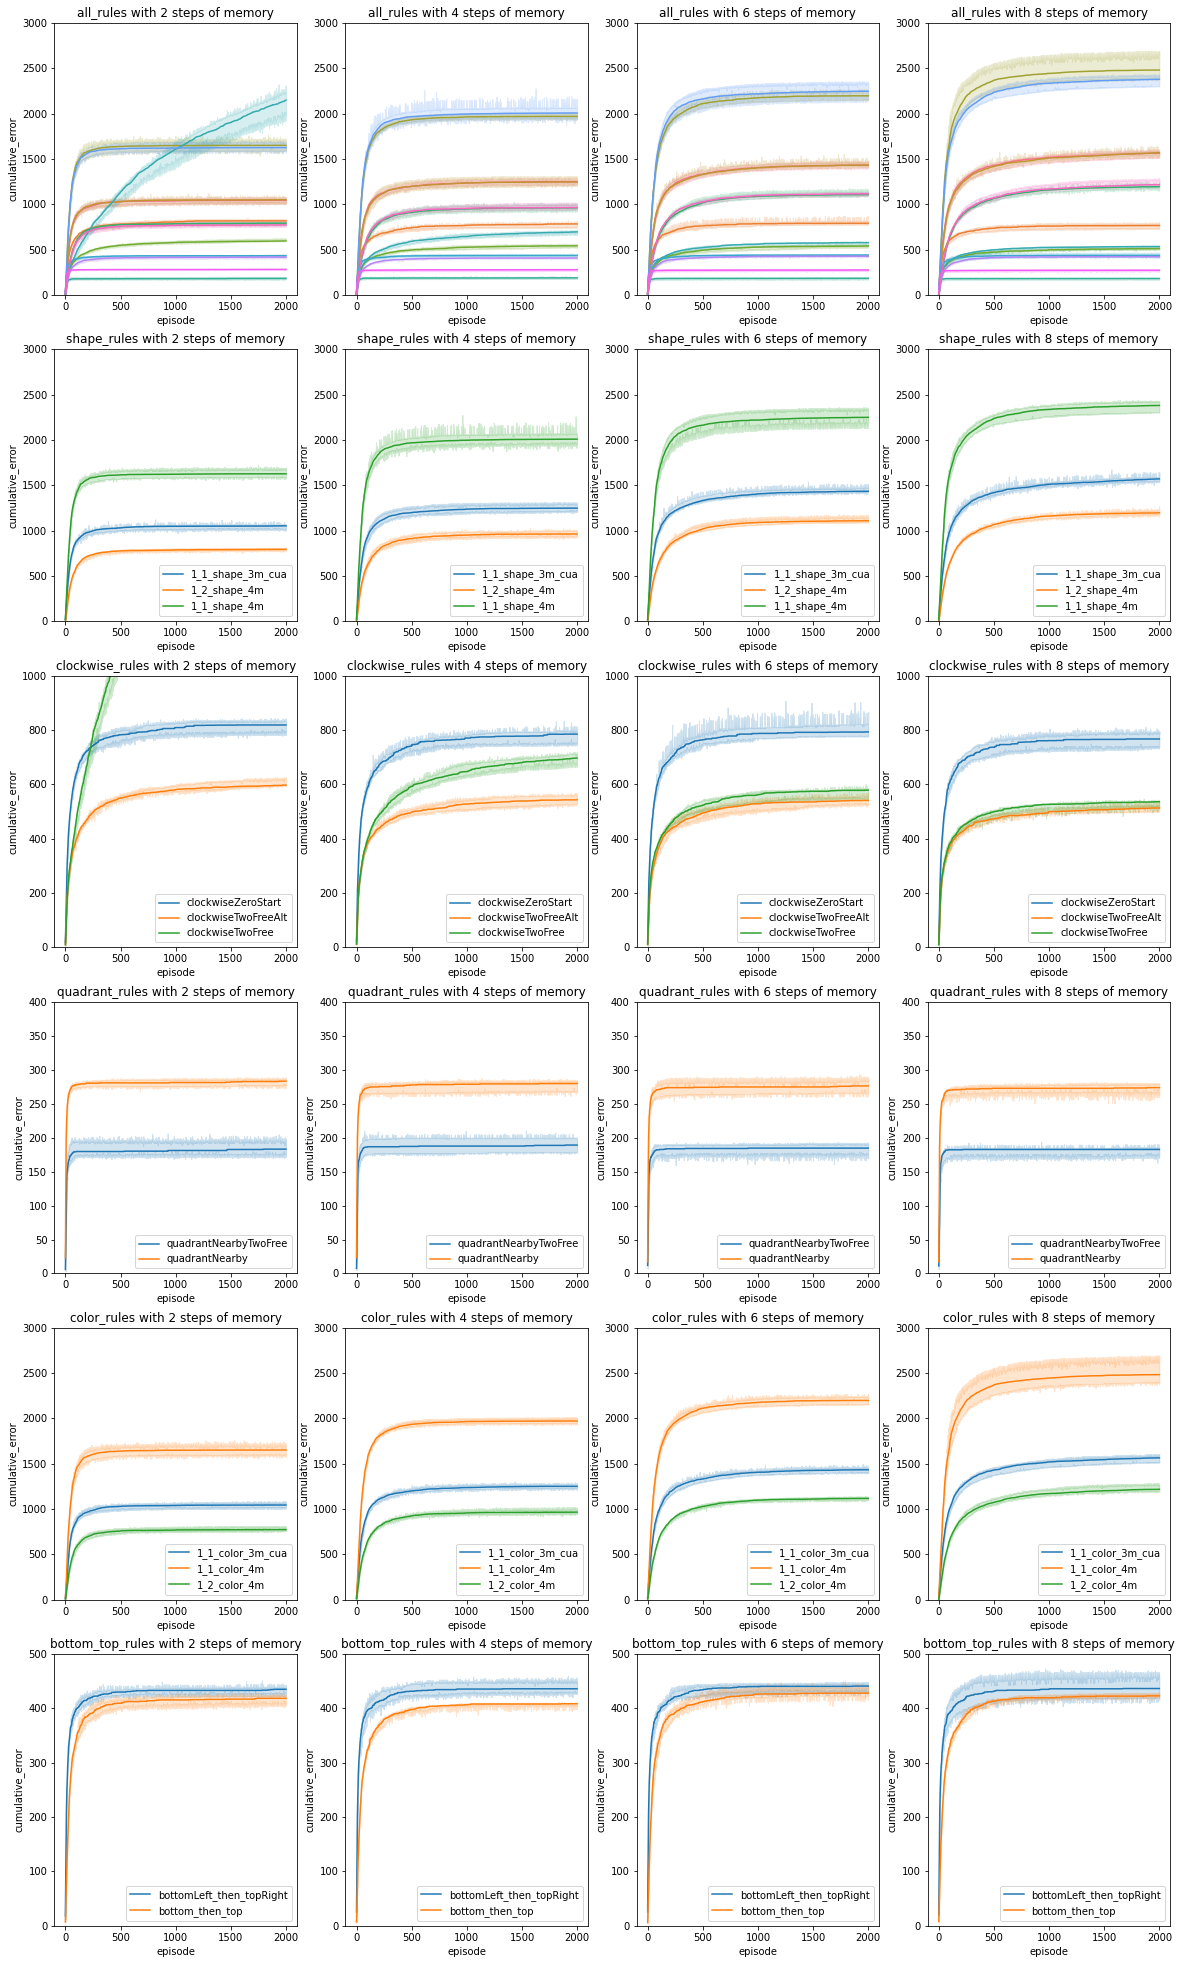

In [5]:

fig = plt.figure(figsize=(20,35))
gs = GridSpec(nrows = len(rules_list),ncols=count_steps)

for j in range(0,len(results)):
    results_df = results[j]["df"]
    step = results[j]["steps"]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,j])
        ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",ci=95,estimator=np.median,n_boot=50,hue="rule")
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])
        if i>0:
            ax.legend(loc="lower right")
        else:
            ax.legend('',frameon=False)

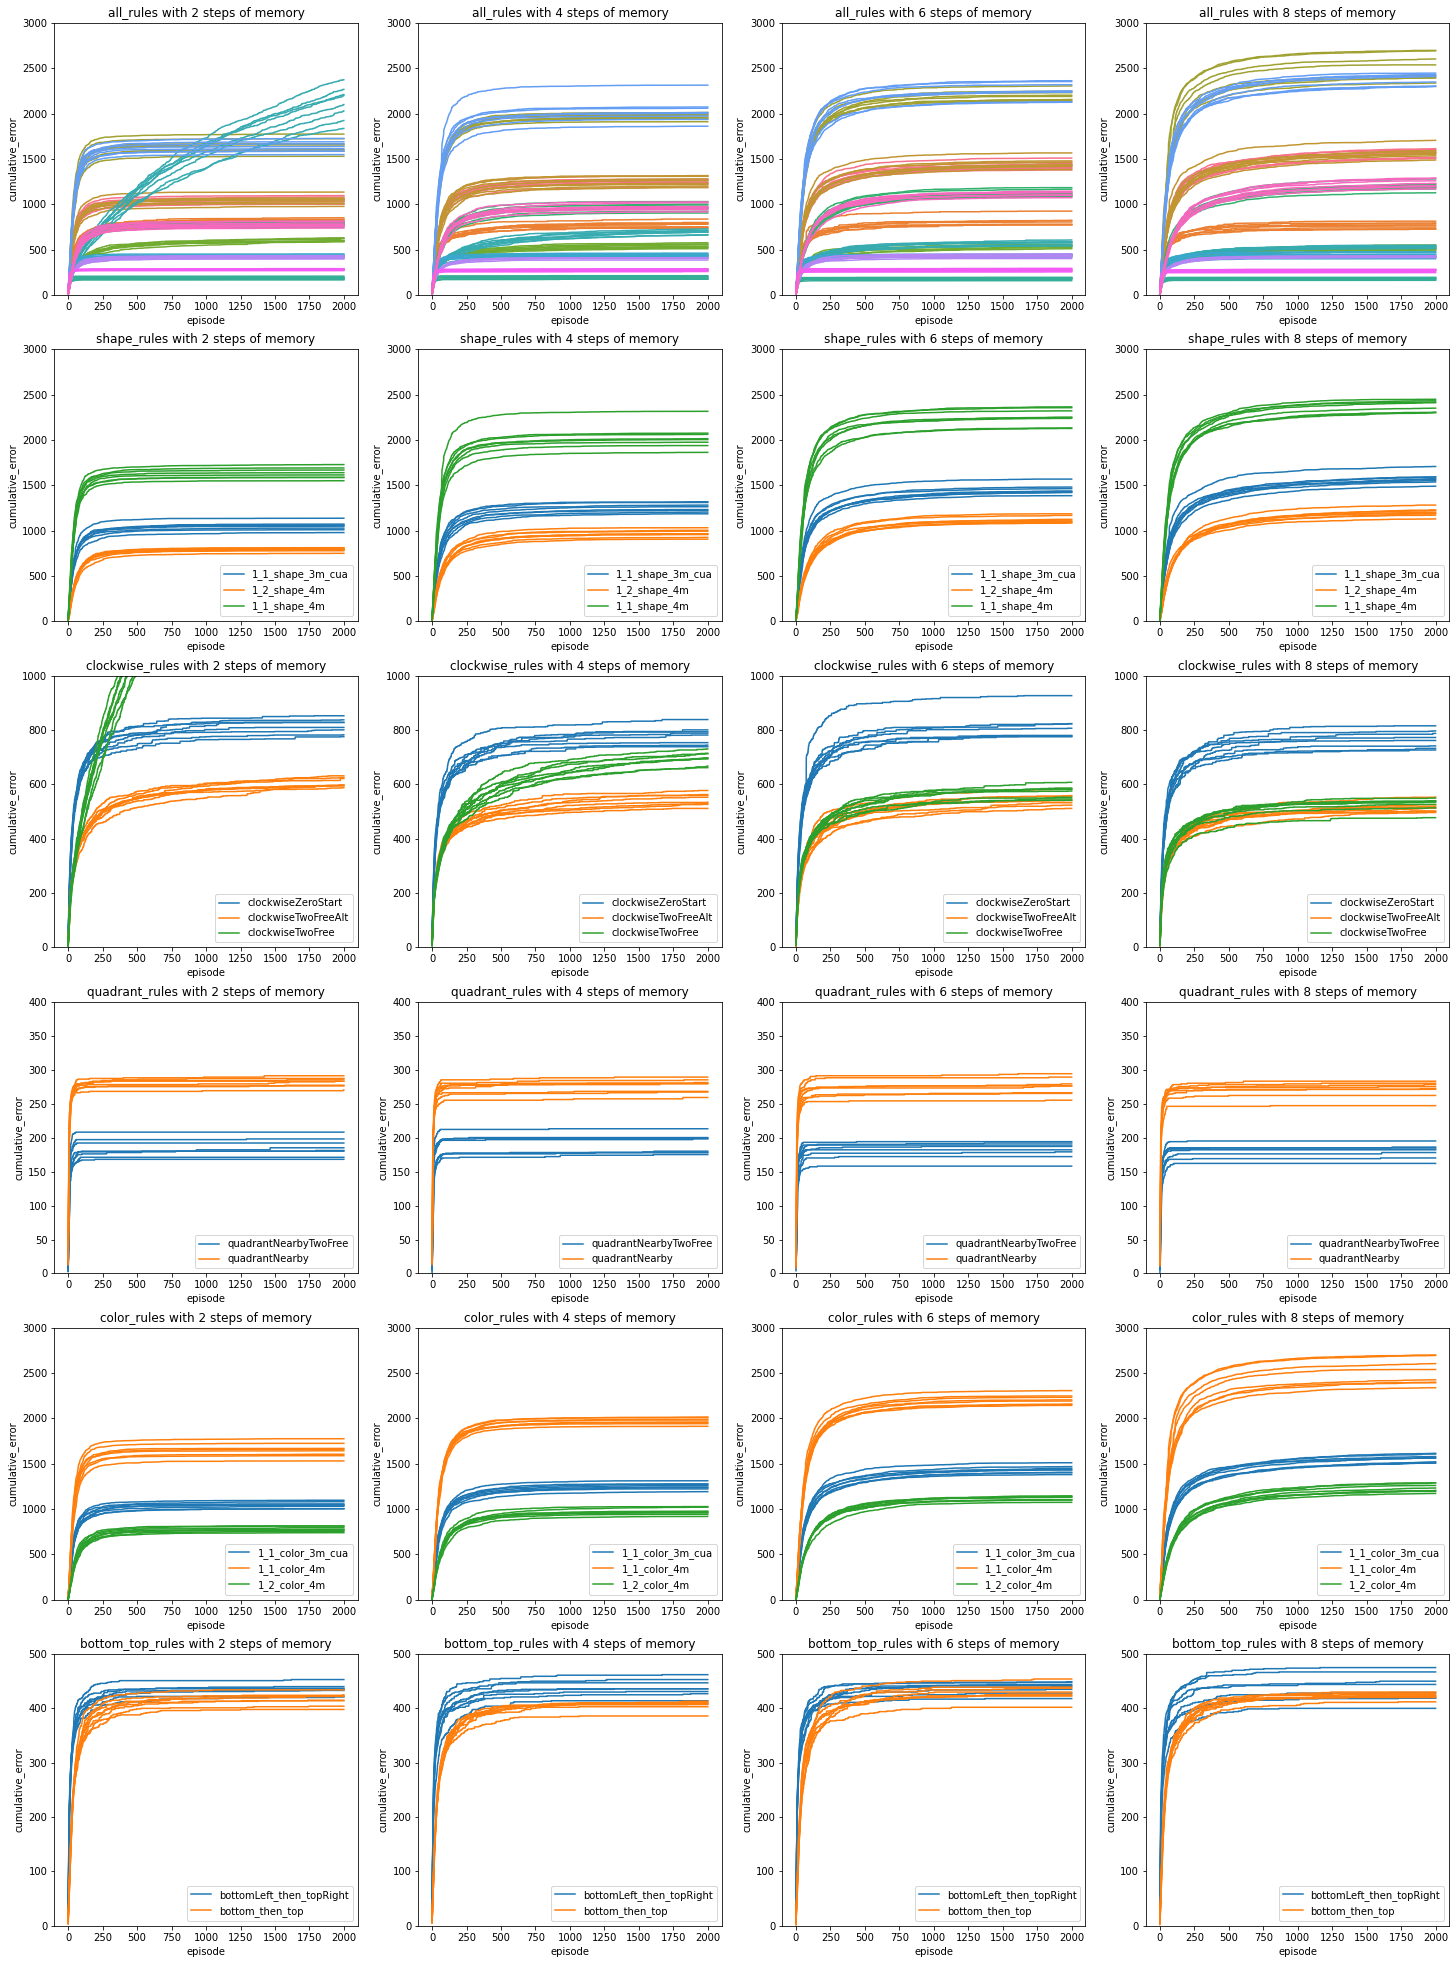

In [21]:
fig = plt.figure(figsize=(25,35))
gs = GridSpec(nrows = len(rules_list),ncols=count_steps)

for j in range(0,len(results)):
    results_df = results[j]["df"]
    step = results[j]["steps"]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,j])
        ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",units="trial",estimator=None,hue="rule")
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])
        if i>0:
            ax.legend(loc="lower right")
        else:
            ax.legend('',frameon=False)
